# Projeto Disciplina KDD & Desafio Axondata

## Foco: Covid-19

### Ideia 2
Realizar agrupamentos de séries temporais relativas ao COVID-19, pra verificar quais países tem comportamentos similares em termos de casos confirmados, casos recuperados e óbitos. Agregar dados demográficos e analisar se isto impacta no agrupamento dos países.

## Configuração Biblioteca e Spark

In [1]:
# importar bibliotecas necessárias
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
import numpy as np
from fbprophet import Prophet

In [2]:
# criar contexto e configuração para o Spark
conf = SparkConf().setAppName("Covid-19 EDA")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

## Explorar Dados - JHU (John Hopkins University)

In [3]:
# Schema para Ler os Dados da JHU
schema_jhu = StructType([StructField('province_state', StringType(), True),
                         StructField('country_region', StringType(), True),
                         StructField('lat', FloatType(), True),
                         StructField('long', FloatType(), True),
                         StructField('date', TimestampType(), True),
                         StructField('value', IntegerType(), True),
                         StructField('alpha_code', StringType(), True),
                         StructField('region_code', IntegerType(), True),
                         StructField('subregion_code', IntegerType(), True),
                         StructField('intermediateregion_code', IntegerType(), True)])

# ler arquivo de casos mundiais confirmados para dataframe Spark
confirmed_world_cases = sqlContext.read.csv('../datasets/time_series_covid19_confirmed_global_narrow.csv', sep=',', header=True, schema=schema_jhu)

# ler arquivo de casos recuperados mundiais para dataframe Spark
recovered_world_cases = sqlContext.read.csv('../datasets/time_series_covid19_recovered_global_narrow.csv', sep=',', header=True, schema=schema_jhu)

# ler arquivo de obitos mundiais para dataframe Spark
deaths_world_cases = sqlContext.read.csv('../datasets/time_series_covid19_deaths_global_narrow.csv', sep=',', header=True, schema=schema_jhu)

In [4]:
# verificar estrutura do dataframe de casos mundiais confirmados
confirmed_world_cases.printSchema()

root
 |-- province_state: string (nullable = true)
 |-- country_region: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- value: integer (nullable = true)
 |-- alpha_code: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- subregion_code: integer (nullable = true)
 |-- intermediateregion_code: integer (nullable = true)



In [5]:
# contagem de objetos de cada dataframe
print("Total de Objetos (base de infectados): {}".format(confirmed_world_cases.count()))
print("Total de Objetos (base de recuperados): {}".format(recovered_world_cases.count()))
print("Total de Objetos (base de óbitos): {}".format(deaths_world_cases.count()))

Total de Objetos (base de infectados): 22968
Total de Objetos (base de recuperados): 21750
Total de Objetos (base de óbitos): 22968


In [6]:
# renomear colunas do dataframe
# como estou usando um schema pros CSVs da JHU, trago todos com o campo Value e renomeio para o nome correto
confirmed_world_cases = confirmed_world_cases.withColumnRenamed("Value", "confirmed")
recovered_world_cases = recovered_world_cases.withColumnRenamed("Value", "recovered")
deaths_world_cases = deaths_world_cases.withColumnRenamed("Value", "deaths")

In [7]:
# Realizar o Merge dos Dataframes em um só
join_condition_1 = [confirmed_world_cases.province_state.eqNullSafe(recovered_world_cases.province_state), \
                    confirmed_world_cases.date == recovered_world_cases.date, \
                    confirmed_world_cases.country_region == recovered_world_cases.country_region]

temp_df = confirmed_world_cases.join(recovered_world_cases, \
                                     on=join_condition_1, how="left") \
                                     .select(confirmed_world_cases.province_state, \
                                             confirmed_world_cases.country_region, \
                                             confirmed_world_cases.lat, \
                                             confirmed_world_cases.long, \
                                             confirmed_world_cases.date, \
                                             confirmed_world_cases.alpha_code, \
                                             confirmed_world_cases.region_code, \
                                             confirmed_world_cases.subregion_code, \
                                             confirmed_world_cases.intermediateregion_code,
                                             confirmed_world_cases.confirmed,
                                             recovered_world_cases.recovered)

join_condition_2 = [temp_df.province_state.eqNullSafe(deaths_world_cases.province_state), \
                    temp_df.date == deaths_world_cases.date, \
                    temp_df.country_region == deaths_world_cases.country_region]

complete_world_df = temp_df.join(deaths_world_cases, \
                                 on=join_condition_2, how="left") \
                                 .select(temp_df.province_state, \
                                         temp_df.country_region, \
                                         temp_df.lat, \
                                         temp_df.long, \
                                         temp_df.date, \
                                         temp_df.alpha_code, \
                                         temp_df.region_code, \
                                         temp_df.subregion_code, \
                                         temp_df.intermediateregion_code,
                                         temp_df.confirmed,
                                         temp_df.recovered,
                                         deaths_world_cases.deaths)

In [8]:
# Contagem de objetos do dataframe completo
print("Total de Objetos (base consolidada) : {}".format(complete_world_df.count()))

Total de Objetos (base consolidada) : 22968


In [9]:
# listar 10 primeiras linhas do dataframe
complete_world_df.limit(10).toPandas()

,province_state,country_region,lat,long,date,alpha_code,region_code,subregion_code,intermediateregion_code,confirmed,recovered,deaths
0,None,Afghanistan,33.0,65.0,2020-04-17,AFG,142,34,None,906,99,30
1,None,Afghanistan,33.0,65.0,2020-04-16,AFG,142,34,None,840,54,30
2,None,Afghanistan,33.0,65.0,2020-04-15,AFG,142,34,None,784,43,25
3,None,Afghanistan,33.0,65.0,2020-04-14,AFG,142,34,None,714,40,23
4,None,Afghanistan,33.0,65.0,2020-04-13,AFG,142,34,None,665,32,21
5,None,Afghanistan,33.0,65.0,2020-04-12,AFG,142,34,None,607,32,18
6,None,Afghanistan,33.0,65.0,2020-04-11,AFG,142,34,None,555,32,18
7,None,Afghanistan,33.0,65.0,2020-04-10,AFG,142,34,None,521,32,15
8,None,Afghanistan,33.0,65.0,2020-04-09,AFG,142,34,None,484,32,15
9,None,Afghanistan,33.0,65.0,2020-04-08,AFG,142,34,None,444,29,14


In [10]:
# Criar coluna com qtde_dias desde o ínicio, pra cada país
complete_world_df = complete_world_df.select("province_state","country_region","lat", "long", "date", \
                                             "alpha_code", "region_code", "subregion_code", "intermediateregion_code", \
                                             "confirmed", "recovered", "deaths", F.row_number()\
                                             .over(Window.partitionBy(complete_world_df['country_region']) \
                                             .orderBy(complete_world_df['date'])).alias("num_days"))

In [11]:
# Estrutura Dataframe consolidado
complete_world_df.printSchema()

root
 |-- province_state: string (nullable = true)
 |-- country_region: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- alpha_code: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- subregion_code: integer (nullable = true)
 |-- intermediateregion_code: integer (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- recovered: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- num_days: integer (nullable = true)



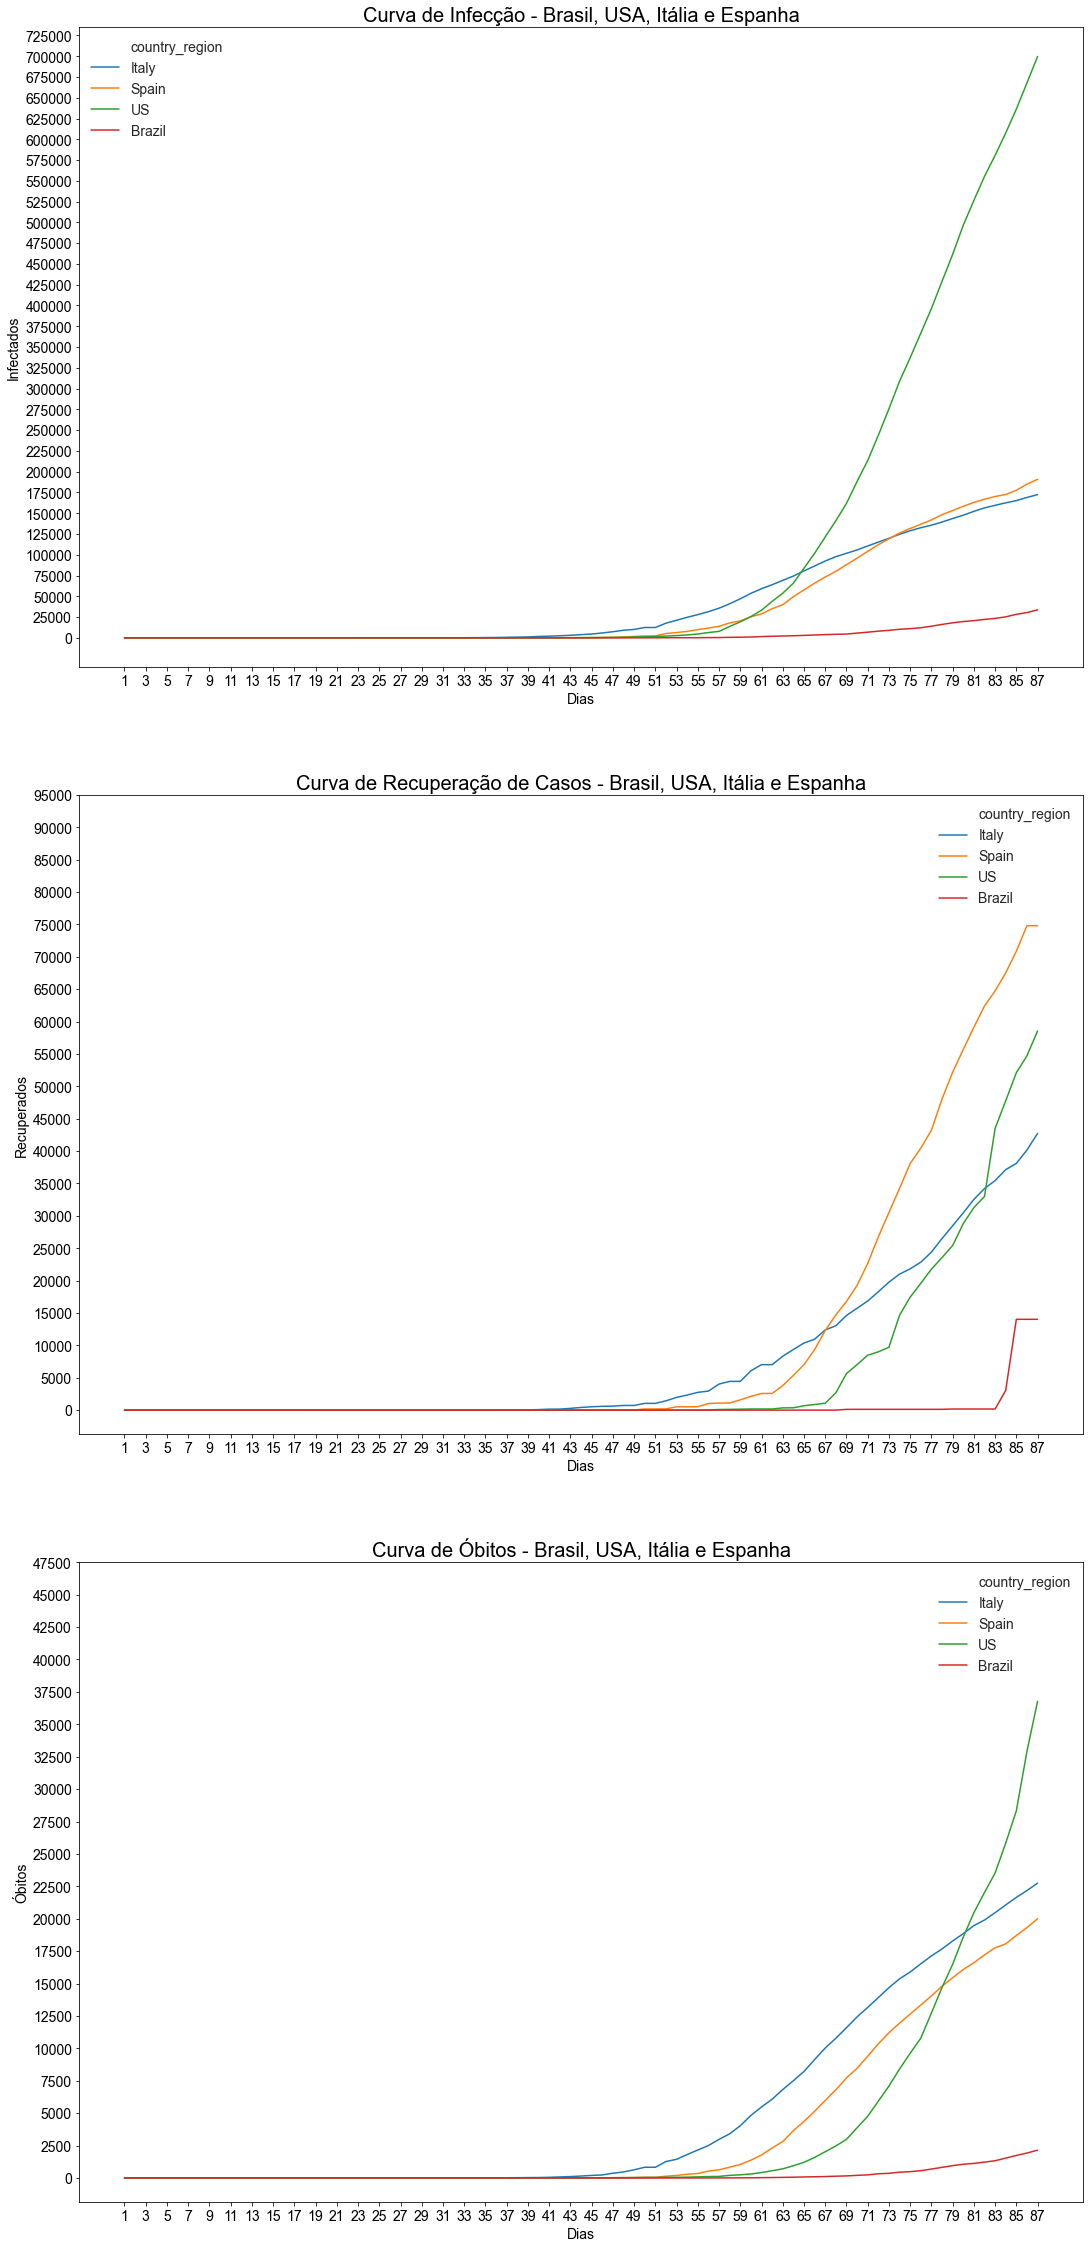

In [12]:
# Gerar gráficos comparando Brasil, Espanha, Italia e USA
fig_dims = (18, 40)
fig, ax = plt.subplots(figsize=fig_dims, nrows=3, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed", hue="country_region", ax=ax[0], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil", "Spain", "US", "Italy"])).toPandas())
ax[0].set_xticks(np.arange(1, 89, 2.0))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yticks(np.arange(0, 750000, 25000.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Curva de Infecção - Brasil, USA, Itália e Espanha", fontsize=20)

# Recuperados
sns.lineplot(x="num_days", y="recovered", hue="country_region", ax=ax[1], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil", "Spain", "US", "Italy"])).toPandas())
ax[1].set_xticks(np.arange(1, 89, 2.0))
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_yticks(np.arange(0, 100000, 5000.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Recuperados", fontsize=14)
ax[1].set_title("Curva de Recuperação de Casos - Brasil, USA, Itália e Espanha", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths", hue="country_region", ax=ax[2], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil", "Spain", "US", "Italy"])).toPandas())
ax[2].set_xticks(np.arange(1, 89, 2.0))
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_yticks(np.arange(0, 50000, 2500.0))
ax[2].legend(fontsize=14, frameon=False)
ax[2].set_xlabel("Dias", fontsize=14)
ax[2].set_ylabel("Óbitos", fontsize=14)
ax[2].set_title("Curva de Óbitos - Brasil, USA, Itália e Espanha", fontsize=20)

plt.show()

## Explorar Base de Dados - Brasil.io

In [13]:
# Schema para Ler os Dados dos Casos da Base Brasil.IO
schema_brasil_io = StructType([StructField('date', TimestampType(), True),
                        StructField('state', StringType(), True),
                        StructField('city', StringType(), True),
                        StructField('place_type', StringType(), True),
                        StructField('confirmed', IntegerType(), True),
                        StructField('deaths', IntegerType(), True),
                        StructField('num_days', IntegerType(), True),
                        StructField('is_last', BooleanType(), True),
                        StructField('estimated_population_2019', IntegerType(), True),
                        StructField('confirmed_by_100k_inhabitants', FloatType(), True),
                        StructField('death_rate', FloatType(), True)])

# ler arquivo de casos mundiais confirmados para dataframe Spark
brasil_io_cases = sqlContext.read.csv('../datasets/caso.csv', sep=',', header=True, schema=schema_brasil_io)

In [14]:
# Contagem de objetos do dataframe Brasil.io
print("Total de Objetos (base consolidada) : {}".format(brasil_io_cases.count()))

Total de Objetos (base consolidada) : 18697


In [15]:
# Estrutura Dataframe consolidado
brasil_io_cases.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- num_days: integer (nullable = true)
 |-- is_last: boolean (nullable = true)
 |-- estimated_population_2019: integer (nullable = true)
 |-- confirmed_by_100k_inhabitants: float (nullable = true)
 |-- death_rate: float (nullable = true)



In [16]:
# listar 10 primeiras linhas do dataframe
brasil_io_cases.limit(10).toPandas()

,date,state,city,place_type,confirmed,deaths,num_days,is_last,estimated_population_2019,confirmed_by_100k_inhabitants,death_rate
0,2020-04-17,AC,None,state,135,5,32,True,881935,12.0,15.30725
1,2020-04-16,AC,None,state,115,5,31,False,881935,12.0,13.03951
2,2020-04-15,AC,None,state,101,4,30,False,881935,12.0,11.45209
3,2020-04-14,AC,None,state,99,3,29,False,881935,12.0,11.22532
4,2020-04-13,AC,None,state,90,3,28,False,881935,12.0,10.20483
5,2020-04-12,AC,None,state,77,2,27,False,881935,12.0,8.73080
6,2020-04-11,AC,None,state,72,2,26,False,881935,12.0,8.16387
7,2020-04-10,AC,None,state,70,2,25,False,881935,12.0,7.93709
8,2020-04-09,AC,None,state,62,2,24,False,881935,12.0,7.03000
9,2020-04-08,AC,None,state,58,2,23,False,881935,12.0,6.57645


In [17]:
# Ranking - Top 5 Cidades por Casos Confirmados
top_5_brasil_confirmed = brasil_io_cases.select('city','confirmed').filter("date == '2020-04-17' and place_type == 'city'").orderBy('confirmed', ascending=False).limit(5)
top_5_brasil_confirmed.show()

+--------------+---------+
|          city|confirmed|
+--------------+---------+
|     São Paulo|     8744|
|Rio de Janeiro|     2946|
|     Fortaleza|     2300|
|        Manaus|     1531|
|        Recife|     1136|
+--------------+---------+



In [18]:
# Ranking - Top 5 Cidades por Óbitos
top_5_brasil_deaths = brasil_io_cases.select('city','deaths').filter("date == '2020-04-17' and place_type == 'city'").orderBy('deaths', ascending=False).limit(5)
top_5_brasil_deaths.show()

+--------------+------+
|          city|deaths|
+--------------+------+
|     São Paulo|   643|
|Rio de Janeiro|   219|
|        Manaus|   127|
|     Fortaleza|   119|
|        Recife|    85|
+--------------+------+



In [19]:
# Cria filtro automatico de cidades para colocar no Gráfico

# filtro top 5 - casos confirmados
filter_confirmed_top5_cities = np.array(top_5_brasil_confirmed.select('city').collect(), dtype = 'object')
filter_confirmed_top5_cities = np.squeeze(filter_confirmed_top5_cities.reshape(filter_confirmed_top5_cities.shape[1], filter_confirmed_top5_cities.shape[0])).tolist()

# filtro top 5 - óbitos
filter_death_top5_cities = np.array(top_5_brasil_deaths.select('city').collect(), dtype = 'object')
filter_death_top5_cities = np.squeeze(filter_death_top5_cities.reshape(filter_death_top5_cities.shape[1], filter_death_top5_cities.shape[0])).tolist()

Text(0.5, 1.0, 'Curva de Óbitos - Top 5 Brasil')

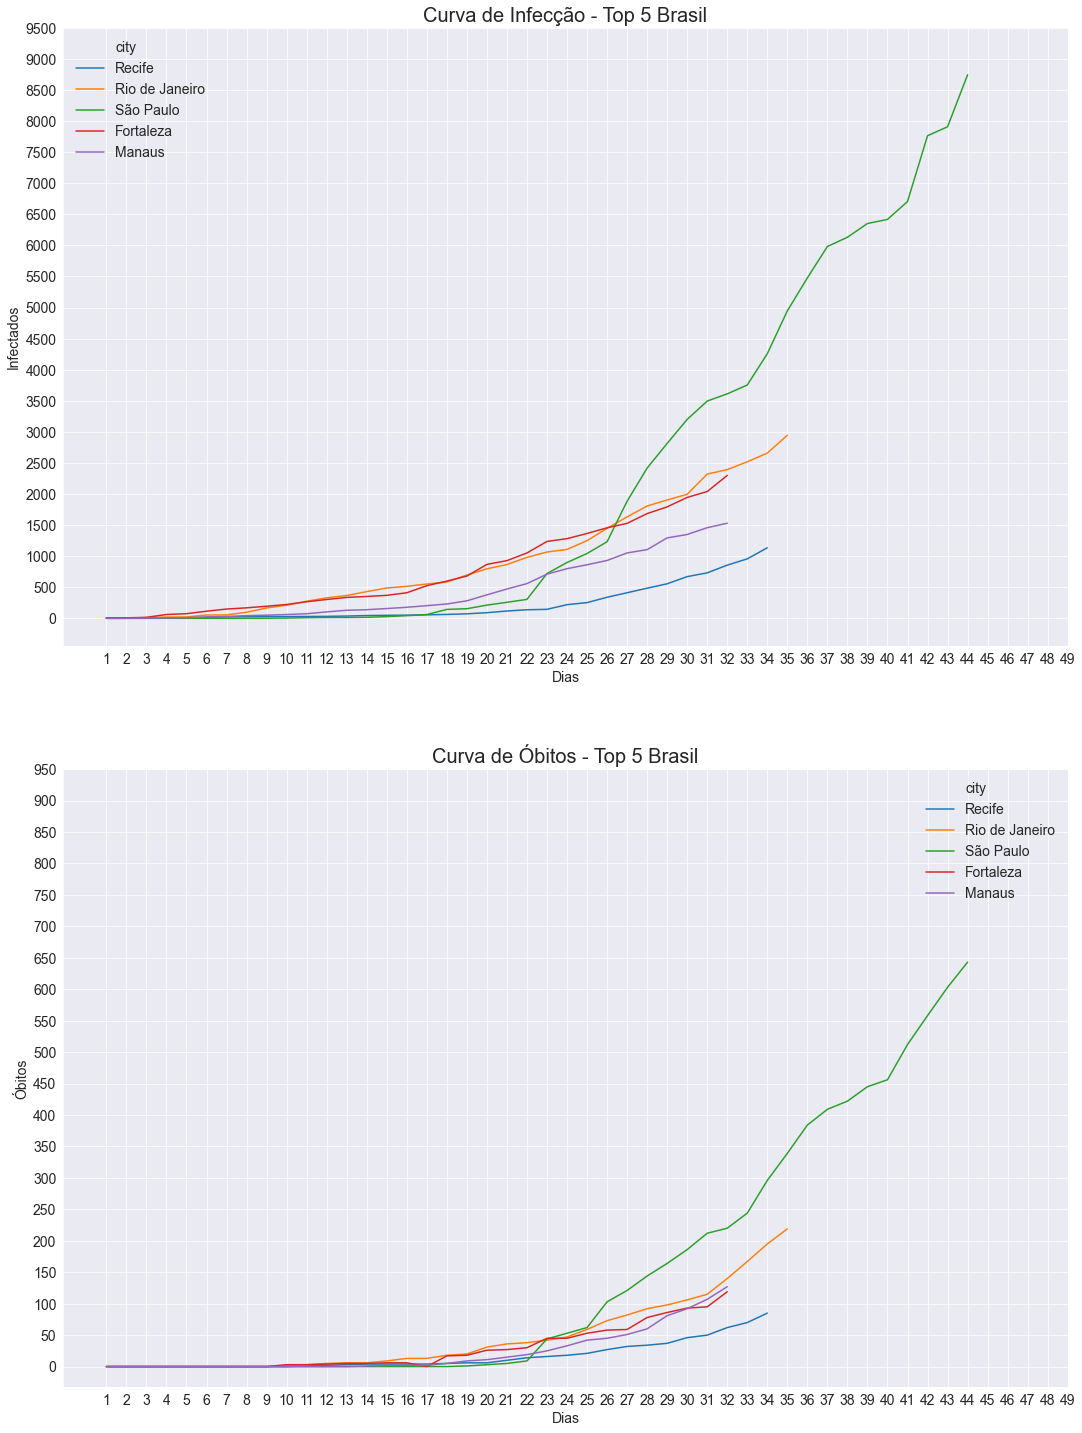

In [20]:
# Gerar gráficos comparando Top 5
fig_dims = (18, 25)
fig, ax = plt.subplots(figsize=fig_dims, nrows=2, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed", hue="city", ax=ax[0], data=brasil_io_cases.filter(brasil_io_cases.city.isin(filter_confirmed_top5_cities)).toPandas())
ax[0].set_xticks(np.arange(1, 50, 1.0))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yticks(np.arange(0, 10000, 500.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Curva de Infecção - Top 5 Brasil", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths", hue="city", ax=ax[1], data=brasil_io_cases.filter(brasil_io_cases.city.isin(filter_death_top5_cities)).toPandas())
ax[1].set_xticks(np.arange(1, 50, 1.0))
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_yticks(np.arange(0, 1000, 50.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Óbitos", fontsize=14)
ax[1].set_title("Curva de Óbitos - Top 5 Brasil", fontsize=20)

## Gerar Série Temporal para realizar previsões

In [21]:
# Criar Janela de Dados por País, Província e Numero de Dias (poderia ser a data também)
my_window = Window.partitionBy("country_region", "province_state").orderBy("num_days")

In [22]:
# Criar coluna para casos confirmados no dia
complete_world_df = complete_world_df.withColumn("prev_confirmed", F.lag(complete_world_df.confirmed).over(my_window))
complete_world_df = complete_world_df.withColumn("confirmed_day", F.when(F.isnull(complete_world_df.confirmed - complete_world_df.prev_confirmed), 0)
                              .otherwise(complete_world_df.confirmed - complete_world_df.prev_confirmed))

In [23]:
# Criar coluna para casos recuperados no dia
complete_world_df = complete_world_df.withColumn("prev_recovered", F.lag(complete_world_df.recovered).over(my_window))
complete_world_df = complete_world_df.withColumn("recovered_day", F.when(F.isnull(complete_world_df.recovered - complete_world_df.prev_recovered), 0)
                              .otherwise(complete_world_df.recovered - complete_world_df.prev_recovered))

In [24]:
# Criar coluna para óbitos no dia
complete_world_df = complete_world_df.withColumn("prev_deaths", F.lag(complete_world_df.deaths).over(my_window))
complete_world_df = complete_world_df.withColumn("deaths_day", F.when(F.isnull(complete_world_df.deaths - complete_world_df.prev_deaths), 0)
                              .otherwise(complete_world_df.deaths - complete_world_df.prev_deaths))

In [25]:
# Remover as colunas de lag
complete_world_df = complete_world_df.drop(*['prev_confirmed', 'prev_recovered', 'prev_deaths'])

In [26]:
# listar 10 primeiras linhas do dataframe
complete_world_df.limit(10).toPandas()

,province_state,country_region,lat,long,date,alpha_code,region_code,subregion_code,intermediateregion_code,confirmed,recovered,deaths,num_days,confirmed_day,recovered_day,deaths_day
0,None,Chad,15.4542,18.732201,2020-01-22,TCD,2,202,17,0,0,0,1,0,0,0
1,None,Chad,15.4542,18.732201,2020-01-23,TCD,2,202,17,0,0,0,2,0,0,0
2,None,Chad,15.4542,18.732201,2020-01-24,TCD,2,202,17,0,0,0,3,0,0,0
3,None,Chad,15.4542,18.732201,2020-01-25,TCD,2,202,17,0,0,0,4,0,0,0
4,None,Chad,15.4542,18.732201,2020-01-26,TCD,2,202,17,0,0,0,5,0,0,0
5,None,Chad,15.4542,18.732201,2020-01-27,TCD,2,202,17,0,0,0,6,0,0,0
6,None,Chad,15.4542,18.732201,2020-01-28,TCD,2,202,17,0,0,0,7,0,0,0
7,None,Chad,15.4542,18.732201,2020-01-29,TCD,2,202,17,0,0,0,8,0,0,0
8,None,Chad,15.4542,18.732201,2020-01-30,TCD,2,202,17,0,0,0,9,0,0,0
9,None,Chad,15.4542,18.732201,2020-01-31,TCD,2,202,17,0,0,0,10,0,0,0


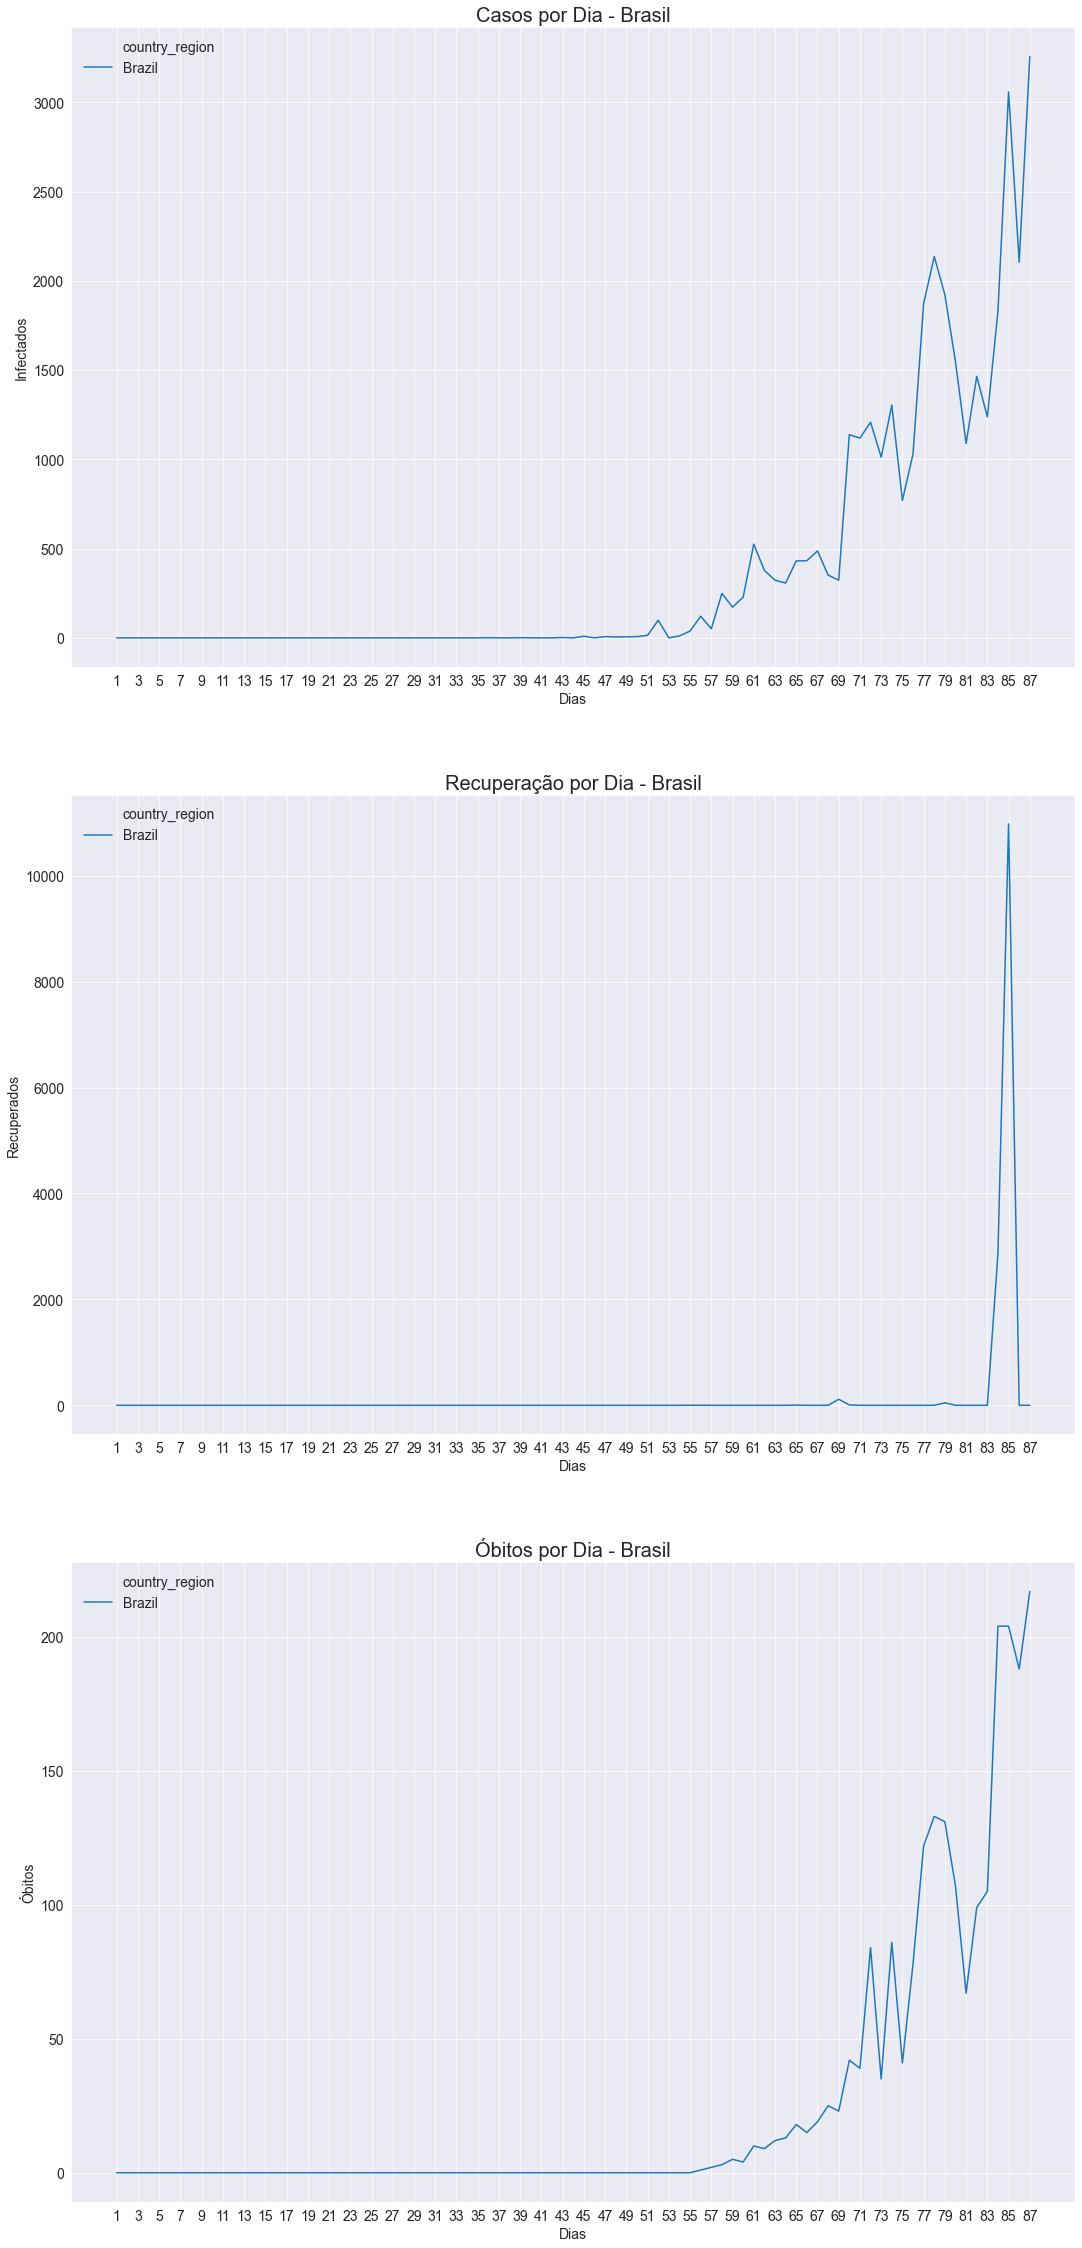

In [27]:
# Gerar gráficos Brasil, com posição diária
fig_dims = (18, 40)
fig, ax = plt.subplots(figsize=fig_dims, nrows=3, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed_day", hue="country_region", ax=ax[0], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas())
ax[0].set_xticks(np.arange(1, 89, 2.0))
ax[0].tick_params(axis='both', which='major', labelsize=14)
#ax[0].set_yticks(np.arange(0, 750000, 25000.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Casos por Dia - Brasil", fontsize=20)

# Recuperados
sns.lineplot(x="num_days", y="recovered_day", hue="country_region", ax=ax[1], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas())
ax[1].set_xticks(np.arange(1, 89, 2.0))
ax[1].tick_params(axis='both', which='major', labelsize=14)
#ax[1].set_yticks(np.arange(0, 100000, 5000.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Recuperados", fontsize=14)
ax[1].set_title("Recuperação por Dia - Brasil", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths_day", hue="country_region", ax=ax[2], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas())
ax[2].set_xticks(np.arange(1, 89, 2.0))
ax[2].tick_params(axis='both', which='major', labelsize=14)
#ax[2].set_yticks(np.arange(0, 50000, 2500.0))
ax[2].legend(fontsize=14, frameon=False)
ax[2].set_xlabel("Dias", fontsize=14)
ax[2].set_ylabel("Óbitos", fontsize=14)
ax[2].set_title("Óbitos por Dia - Brasil", fontsize=20)

plt.show()

In [28]:
# Verificar Brasil
complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()

,province_state,country_region,lat,long,date,alpha_code,region_code,subregion_code,intermediateregion_code,confirmed,recovered,deaths,num_days,confirmed_day,recovered_day,deaths_day
0,None,Brazil,-14.235,-51.925301,2020-01-22,BRA,19,419,5,0,0,0,1,0,0,0
1,None,Brazil,-14.235,-51.925301,2020-01-23,BRA,19,419,5,0,0,0,2,0,0,0
2,None,Brazil,-14.235,-51.925301,2020-01-24,BRA,19,419,5,0,0,0,3,0,0,0
3,None,Brazil,-14.235,-51.925301,2020-01-25,BRA,19,419,5,0,0,0,4,0,0,0
4,None,Brazil,-14.235,-51.925301,2020-01-26,BRA,19,419,5,0,0,0,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,None,Brazil,-14.235,-51.925301,2020-04-13,BRA,19,419,5,23430,173,1328,83,1238,0,105
83,None,Brazil,-14.235,-51.925301,2020-04-14,BRA,19,419,5,25262,3046,1532,84,1832,2873,204
84,None,Brazil,-14.235,-51.925301,2020-04-15,BRA,19,419,5,28320,14026,1736,85,3058,10980,204
85,None,Brazil,-14.235,-51.925301,2020-04-16,BRA,19,419,5,30425,14026,1924,86,2105,0,188


## Forecast usando Facebook Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Previsão Confirmados: 10 dias
           ds         yhat   yhat_lower   yhat_upper
87 2020-04-18  2089.537427  1788.221442  2390.763202
88 2020-04-19  2134.186666  1842.699128  2424.257687
89 2020-04-20  2167.332252  1891.300338  2474.615246
90 2020-04-21  2400.225882  2095.881730  2693.244326
91 2020-04-22  2554.185218  2240.653145  2867.947326
92 2020-04-23  2540.941495  2246.516683  2845.156618
93 2020-04-24  2627.046221  2294.229121  2937.679951
94 2020-04-25  2564.948943  2304.578204  2856.129846
95 2020-04-26  2609.598182  2312.785085  2903.652618
96 2020-04-27  2642.743767  2346.801532  2931.486193


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Previsão Recuperados: 10 dias
           ds         yhat   yhat_lower   yhat_upper
87 2020-04-18   480.540736  -973.647746  1962.410066
88 2020-04-19   480.630816  -864.488375  1924.773811
89 2020-04-20   490.292501 -1001.372471  1846.667387
90 2020-04-21   720.711510  -752.780409  2132.794231
91 2020-04-22  1361.650680     2.242225  2897.220365
92 2020-04-23   521.578609  -904.800033  2007.886285
93 2020-04-24   517.818737  -991.769175  1969.009367
94 2020-04-25   554.870130  -888.148109  2124.134448
95 2020-04-26   554.960210  -803.185262  2005.598229
96 2020-04-27   564.621895  -870.625947  1983.024291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Previsão Óbitos: 10 dias
           ds        yhat  yhat_lower  yhat_upper
87 2020-04-18  164.063268  143.329828  183.466709
88 2020-04-19  168.713388  148.897396  187.641579
89 2020-04-20  176.780029  156.487984  197.032975
90 2020-04-21  195.346281  174.523703  213.948691
91 2020-04-22  200.776742  181.906350  220.202790
92 2020-04-23  207.772236  188.986091  227.181574
93 2020-04-24  208.680448  189.565326  228.412367
94 2020-04-25  210.055121  188.804697  230.592606
95 2020-04-26  214.705241  195.022872  234.846536
96 2020-04-27  222.771882  203.135766  243.362931


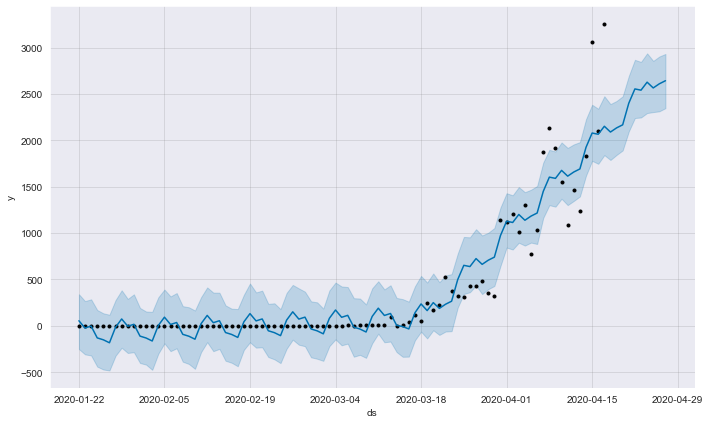

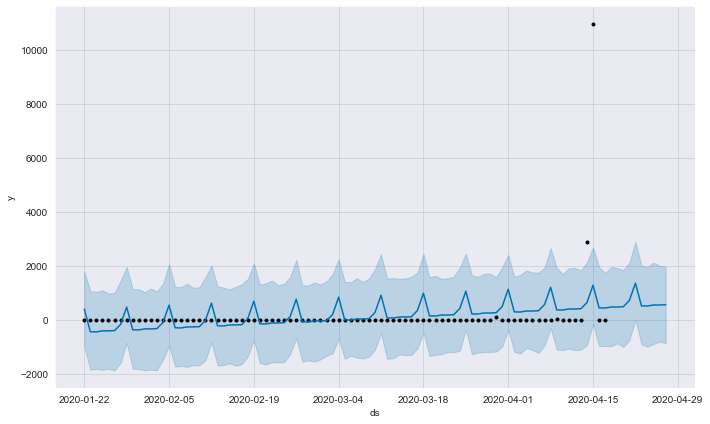

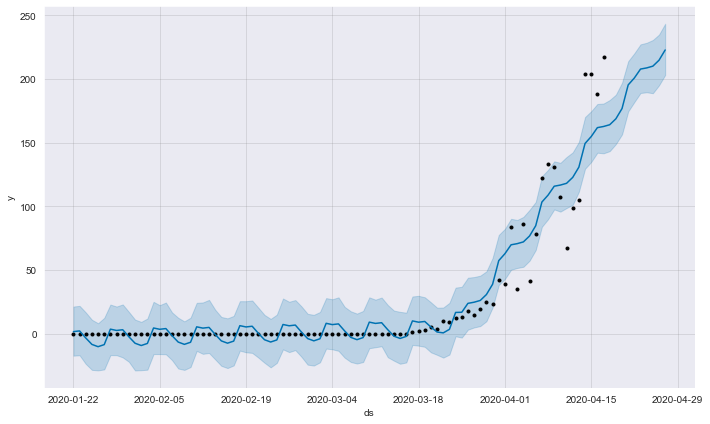

In [47]:
# confirmados
X = complete_world_df.selectExpr('date as ds', 'confirmed_day as y').filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()
model_confirmed = Prophet()
model_confirmed.fit(X)
future_confirmed_brazil = model_confirmed.make_future_dataframe(periods=10)
forecast_confirmed_brazil = model_confirmed.predict(future_confirmed_brazil)
print('Previsão Confirmados: 10 dias')
print(forecast_confirmed_brazil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# recuperados
X = complete_world_df.selectExpr('date as ds', 'recovered_day as y').filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()
model_recovered = Prophet()
model_recovered.fit(X)
future_recovered_brazil = model_recovered.make_future_dataframe(periods=10)
forecast_recovered_brazil = model_recovered.predict(future_recovered_brazil)
print('Previsão Recuperados: 10 dias')
print(forecast_recovered_brazil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# óbitos
X = complete_world_df.selectExpr('date as ds', 'deaths_day as y').filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()
model_deaths = Prophet()
model_deaths.fit(X)
future_deaths_brazil = model_deaths.make_future_dataframe(periods=10)
forecast_deaths_brazil = model_deaths.predict(future_deaths_brazil)
print('Previsão Óbitos: 10 dias')
print(forecast_deaths_brazil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# Gráficos Forecast FBProphet
fig1 = model_confirmed.plot(forecast_confirmed_brazil)
fig2 = model_recovered.plot(forecast_recovered_brazil)
fig3 = model_deaths.plot(forecast_deaths_brazil)

## Datasets COVID19

- https://data.brasil.io/dataset/covid19/_meta/list.html
- https://github.com/CSSEGISandData/COVID-19
- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
- https://github.com/beoutbreakprepared/nCoV2019?files=1
- https://www.kaggle.com/smid80/coronavirus-covid19-tweets
- https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures
- https://www.kaggle.com/unanimad/corona-virus-brazil
- https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255
- https://github.com/github/covid-19-repo-data
- https://github.com/datasets/covid-19
- https://github.com/pomber/covid19

## Dados Demográficos (Brasil e Mundo)

- https://data.worldbank.org/indicator/sp.pop.totl
- https://www.kaggle.com/crisparada/brazilian-cities
- https://www.kaggle.com/fernandol/countries-of-the-world

## Artigos, estudos e recursos - COVID-19
- https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
- https://medium.com/data-for-science/epidemic-modeling-102-all-covid-19-models-are-wrong-but-some-are-useful-c81202cc6ee9
- https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html
- https://medium.com/@flohagenbuch/vemos-luz-no-fim-do-túnel-covid-19-96663d3cf1ed
- https://investnews.com.br/cafeina/novo-estudo-contesta-previsoes-sobre-mortes-pela-covid-19-no-brasil/
- https://science.sciencemag.org/content/early/2020/04/14/science.abb5793.full
- https://www.medrxiv.org/content/10.1101/2020.02.27.20028027v3
- https://towardsdatascience.com/5-datasets-about-covid-19-you-can-use-right-now-46307b1406a?gi=8f8a40a7b45b
- https://www.kaggle.com/brandao/covid19-reduzindo-falsos-negativos
- https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions
- https://towardsdatascience.com/top-5-r-resources-on-covid-19-coronavirus-1d4c8df6d85f

## Papers, Estudos, Artigos - Agrupamento de Séries Temporais